# Xây dựng cây quyết định và rừng cây trên dữ liệu Titanic lấy từ

In [2]:
# import libraries
import numpy as np                 
import pandas as pd               
import matplotlib.pyplot as plt    
import seaborn as sns

from sklearn.model_selection import train_test_split   
from sklearn.model_selection import GridSearchCV     
from sklearn import tree                            
from sklearn.ensemble import RandomForestClassifier    
from sklearn.metrics import accuracy_score, roc_auc_score

##### nạp dữ liệu 

In [11]:
df = pd.read_csv('datasets/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Tiền xử lý dữ liệu

In [12]:
# 1. Chọn các cột đặc trưng (features) và cột mục tiêu (target)
# Chúng ta sẽ dự đoán 'Survived'
# Dựa trên: Pclass, Sex, Age, SibSp (anh chị em/vợ chồng), Parch (cha mẹ/con cái), Fare, Embarked
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

df_processed = df[features + [target]].copy() # Tạo bản sao để xử lý
df_processed.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [13]:
df_processed.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Survived      0
dtype: int64

In [14]:
# 2. Xử lý giá trị thiếu (Missing Values)
# 2.1. Cột 'Age': Điền tuổi trung bình vào các ô bị thiếu
# Dùng .median() (trung vị) sẽ tốt hơn .mean() (trung bình) vì ít bị ảnh hưởng bởi các giá trị ngoại lai
age_median = df_processed['Age'].median()
df_processed['Age'] = df_processed['Age'].fillna(age_median)
print(f"Đã điền giá trị thiếu cho 'Age' bằng: {age_median}")

# 2.2. Cột 'Embarked': Điền giá trị xuất hiện nhiều nhất (mode)
embarked_mode = df_processed['Embarked'].mode()[0] # [0] vì mode() trả về 1 Series
df_processed['Embarked'] = df_processed['Embarked'].fillna(embarked_mode)
print(f"Đã điền giá trị thiếu cho 'Embarked' bằng: {embarked_mode}")

Đã điền giá trị thiếu cho 'Age' bằng: 28.0
Đã điền giá trị thiếu cho 'Embarked' bằng: S


In [15]:
# 3. Mã hóa các biến phân loại (Categorical Encoding)
# Máy tính không hiểu chữ 'male', 'female'. Phải đổi sang số.
# 3.1. Cột 'Sex': Dùng .map()
df_processed['Sex'] = df_processed['Sex'].map({'male': 0, 'female': 1})

# 3.2. Cột 'Embarked': Dùng pd.get_dummies()
# Cột này có 3 giá trị (S, C, Q). Chúng ta sẽ tạo 3 cột mới (0 hoặc 1)
df_processed = pd.get_dummies(df_processed, columns=['Embarked'], drop_first=True)

In [16]:
df_processed.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,0,False,True
1,1,1,38.0,1,0,71.2833,1,False,False
2,3,1,26.0,0,0,7.9250,1,False,True
3,1,1,35.0,1,0,53.1000,1,False,True
4,3,0,35.0,0,0,8.0500,0,False,True


In [17]:
df_processed.isnull().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Survived      0
Embarked_Q    0
Embarked_S    0
dtype: int64

#### Chuẩn bị dữ liệu cho tập train và test

In [19]:
# Lấy danh sách các cột đặc trưng sau khi đã xử lý
# (Cột 'Embarked' đã bị thay thế bởi 'Embarked_Q' và 'Embarked_S')
processed_feature_names = df_processed.drop(target, axis=1).columns.tolist()

# Tách X (features) và y (target)
X = df_processed[processed_feature_names].values
y = df_processed[target].values

# Chia dữ liệu: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       
    random_state=24      
)

#### Xây dựng cây quyết định

In [22]:
# 1. Tạo Cây quyết định
# Tạo 1 cây đơn giản với max_depth=3 để xem thử
dt_simple = tree.DecisionTreeClassifier(max_depth=3)
dt_simple.fit(X_train, y_train)

print("\n--- Cây quyết định đơn giản (max_depth=3) ---")
print(f"Độ chính xác (Accuracy) trên tập train: {dt_simple.score(X_train, y_train):.4f}")
print(f"Độ chính xác (Accuracy) trên tập test:  {dt_simple.score(X_test, y_test):.4f}")


--- Cây quyết định đơn giản (max_depth=3) ---
Độ chính xác (Accuracy) trên tập train: 0.8188
Độ chính xác (Accuracy) trên tập test:  0.8156


In [23]:
# 2. Tối ưu Cây quyết định 
# Chúng ta sẽ dùng GridSearchCV để tìm 'max_depth' tốt nhất
dt = tree.DecisionTreeClassifier()
params = {'max_depth': [2, 3, 4, 5, 6, 8, 10, 12]} 

cv_dt = GridSearchCV(dt, param_grid=params, scoring='accuracy', cv=4, verbose=1)
cv_dt.fit(X_train, y_train)

print(f"Tham số max_depth tốt nhất tìm được: {cv_dt.best_params_}")
print(f"Độ chính xác (Accuracy) tốt nhất trên tập test: {cv_dt.score(X_test, y_test):.4f}")

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Tham số max_depth tốt nhất tìm được: {'max_depth': 4}
Độ chính xác (Accuracy) tốt nhất trên tập test: 0.8156


In [24]:
# Lấy ra mô hình tốt nhất
best_dt = cv_dt.best_estimator_

#### Xây dựng rừng cây

In [25]:
# Tạo mô hình Rừng cây 
rf = RandomForestClassifier(random_state=4) 

# Xác định lưới tham số để tìm kiếm 
# Tìm số cây (n_estimators) từ 10 đến 100
rf_params = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
# Tạo đối tượng GridSearchCV
cv_rf = GridSearchCV(rf, param_grid=rf_params, scoring='accuracy', cv=4, verbose=1) 
cv_rf.fit(X_train, y_train) 

print(f"Tham số n_estimators tốt nhất tìm được: {cv_rf.best_params_}")
print(f"Độ chính xác (Accuracy) tốt nhất trên tập test: {cv_rf.score(X_test, y_test):.4f}")

# Lấy ra mô hình tốt nhất
best_rf = cv_rf.best_estimator_

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Tham số n_estimators tốt nhất tìm được: {'n_estimators': 30}
Độ chính xác (Accuracy) tốt nhất trên tập test: 0.8101


#### Đánh giá mô hình

In [ ]:
# Lấy độ quan trọng của các đặc trưng từ mô hình tốt nhất 
importances = best_rf.feature_importances_

# Tạo DataFrame để xem cho dễ 
feat_imp_df = pd.DataFrame({
    'Feature': processed_feature_names,
    'Importance': importances
})

feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
print(feat_imp_df)

      Feature  Importance
5        Fare    0.284666
2         Age    0.268415
1         Sex    0.250531
0      Pclass    0.072905
3       SibSp    0.050149
4       Parch    0.043283
7  Embarked_S    0.020230
6  Embarked_Q    0.009821


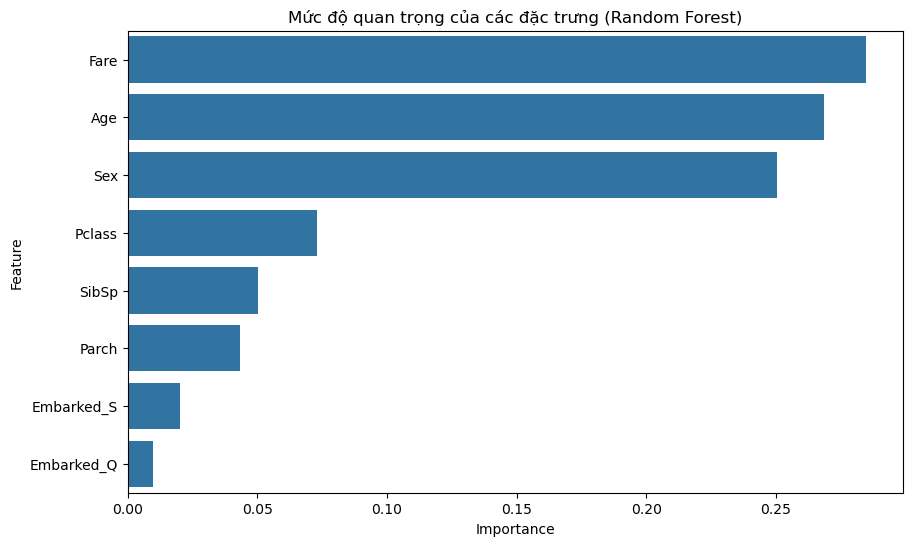

In [27]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Mức độ quan trọng của các đặc trưng (Random Forest)')
plt.show()

Kết thúc